## Importing the Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,precision_score, recall_score
# 
# import re
# import spacy
# sp = spacy.load('en_core_web_sm')

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import transformers
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader,TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import time
import datetime

# import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
color_palette=['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(color_palette))

rcParams['figure.figsize']= 10,5

seed=42
np.random.seed(seed)
torch.manual_seed(seed)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Importing variables from the preprocessing notebook as csv files

In [30]:
X = pd.read_csv('X.csv')
y = np.loadtxt('y.csv', delimiter=',')

In [31]:
X.shape

(8930, 2)

In [32]:
y.shape

(8930,)

In [33]:
# Check for null values in a specific column 'column_name'
null_count = X['preprocessed_text'].isnull().sum()

# Display the count of null values in 'column_name'
print("Number of null values in 'column_name':", null_count)


Number of null values in 'column_name': 2


## Loading Bert Model

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
token_lens = []

for txt in X.preprocessed_text.dropna():
    tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
    token_lens.append(len(tokens))


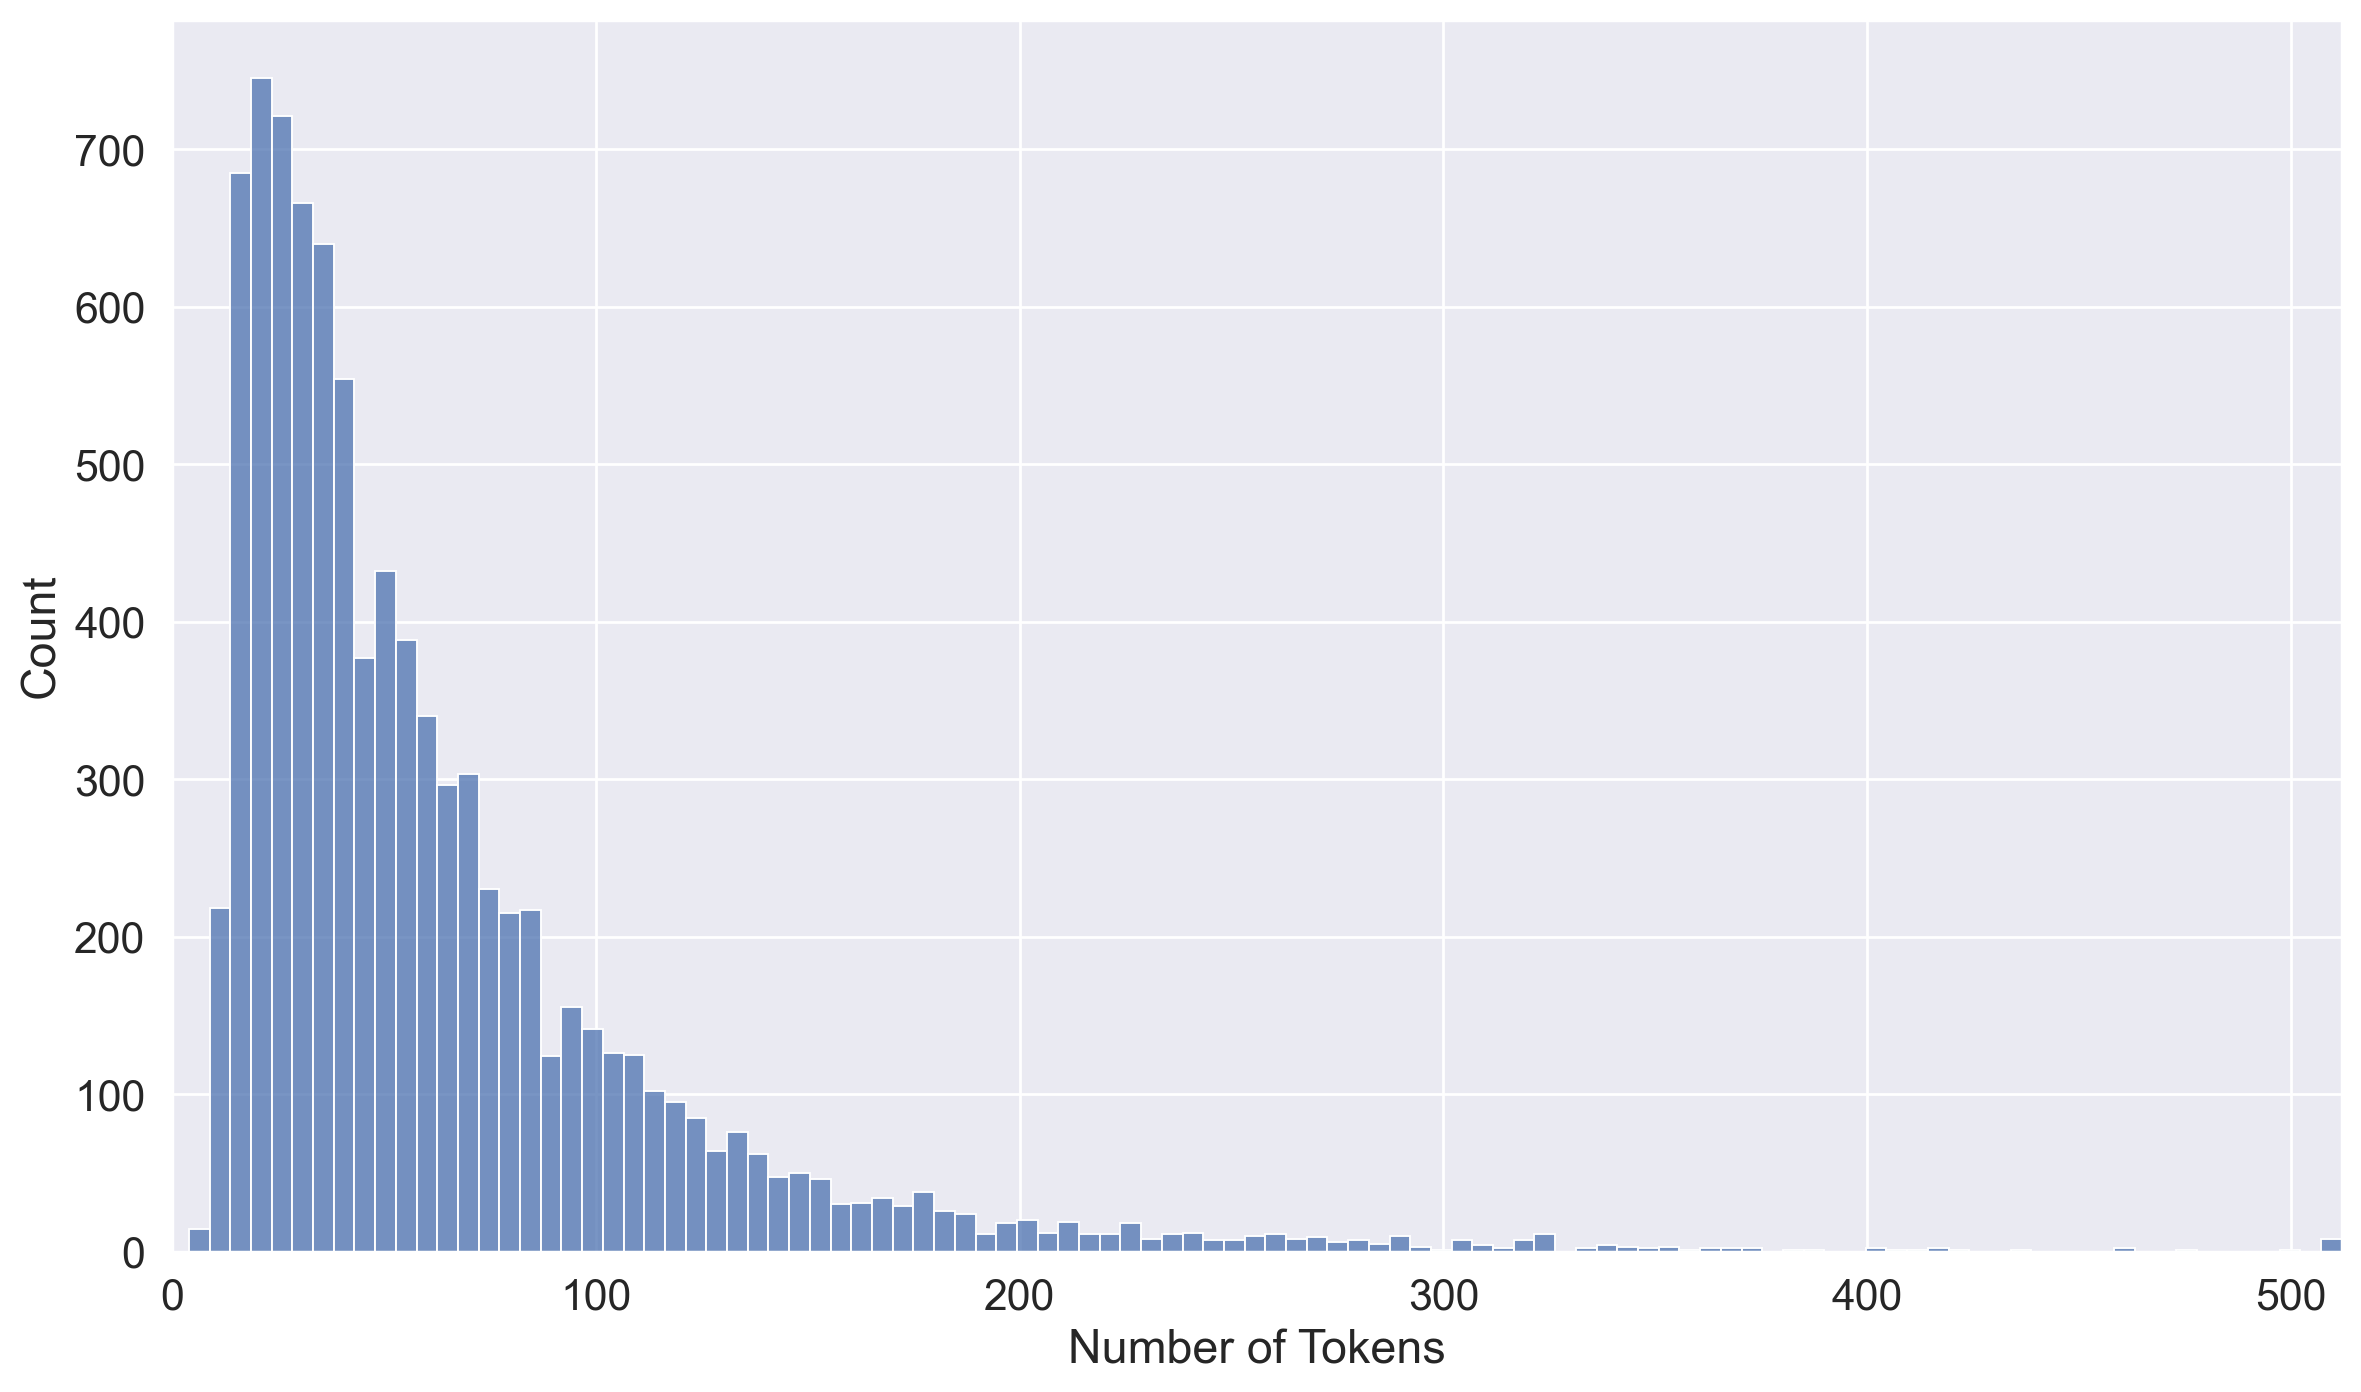

In [7]:
sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (14,8)
sns.histplot(token_lens)
plt.xlim([0, 512])
plt.xlabel('Number of Tokens')
plt.show()

In [10]:
max_seq_length = 300

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X['preprocessed_text'],y , test_size=0.3, random_state = 42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state = 42, stratify= y_test)

In [12]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [13]:
train_reviews = x_train.tolist()
val_reviews = x_val.tolist()
test_reviews = x_test.tolist()

In [15]:
train_reviews = [str(review) for review in train_reviews if pd.notna(review)]
val_reviews = [str(review) for review in val_reviews if pd.notna(review)]
test_reviews = [str(review) for review in test_reviews if pd.notna(review)]


In [16]:
# Train dataset
train_input_ids = [tokenizer.encode(train_reviews[i],add_special_tokens = True, max_length=max_seq_length, truncation=True) for i in range(0,len(train_reviews))]
# Val dataset
val_input_ids = [tokenizer.encode(val_reviews[i],add_special_tokens = True, max_length=max_seq_length, truncation=True) for i in range(0,len(val_reviews))]
# Test dataset
test_input_ids = [tokenizer.encode(test_reviews[i],add_special_tokens = True, max_length=max_seq_length, truncation=True) for i in range(0,len(test_reviews))]

In [18]:
from keras.utils import pad_sequences

# Train dataset
train_input_ids = pad_sequences(train_input_ids, maxlen=max_seq_length, dtype="long",
                                value=0, truncating="post", padding="post")

# Validation dataset
val_input_ids = pad_sequences(val_input_ids, maxlen=max_seq_length, dtype="long",
                              value=0, truncating="post", padding="post")

# Test dataset
test_input_ids = pad_sequences(test_input_ids, maxlen=max_seq_length, dtype="long",
                               value=0, truncating="post", padding="post")

In [19]:
# Create attention masks

# Train dataset
train_attention_masks = [[int(token_id > 0) for token_id in review]
                         for review in train_input_ids]
# dev dataset
val_attention_masks = [[int(token_id > 0) for token_id in review]
                       for review in val_input_ids]
# Test dataset
test_attention_masks = [[int(token_id > 0) for token_id in review]
                        for review in test_input_ids]

In [21]:
# input_ids
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
test_inputs = torch.tensor(test_input_ids)
# labels
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)
# attention masks
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)
test_masks = torch.tensor(test_attention_masks)

In [22]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

AssertionError: Size mismatch between tensors

In [ ]:
# Number of classes / labels
n_classes = y_train.nunique()
n_classes

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # The 12-layer BERT model with an uncased vocab
    num_labels = 2, # For binary classification  
    output_attentions = False, # Not to return attentions weights
    output_hidden_states = False, # Not to return all hidden-states
)


In [ ]:
model = model.to(device)

In [ ]:
epochs=2

optimizer=AdamW(model.parameters(),lr=3e-5)
total_steps=len(train_dataloader)*epochs

# Create the learning rate scheduler
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
# Define loss function and move it to GPU
loss_fn=nn.CrossEntropyLoss().to(device)

In [ ]:
def format_time(elapsed):
    # Round to the nearest second
    elapsed_round = int(round(elapsed))
    # Format time in hh:mm:ss
    return str(datetime.timedelta(seconds = elapsed_round))

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from transformers import BertTokenizer, BertModel
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [ ]:
# Tokenize and get embeddings for each review
embeddings = []
max_seq_length = 512
for review in X['preprocessed_text']:
    tokens = tokenizer.encode(review, add_special_tokens=True)
    input_ids = torch.tensor([tokens])
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs.last_hidden_state
        mean_embedding = last_hidden_states.mean(dim=1).squeeze().numpy()
        embeddings.append(mean_embedding)


In [ ]:

# Convert embeddings to NumPy array
embedding_array = np.array(embeddings)

# Perform unsupervised clustering (KMeans)
num_clusters = 2 # You can adjust this based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_array)

# Add cluster labels to the DataFrame
X['cluster'] = cluster_labels

# Display the distribution of sentiments in each cluster
for cluster_id in range(num_clusters):
    cluster_data = X[X['cluster'] == cluster_id]['sentiment']
    print(f"Cluster {cluster_id} - Sentiment Distribution:")
    print(cluster_data.value_counts())
    print("\n")

In [21]:
from transformers import TFBertModel, BertTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model
import numpy as np

# Convert DataFrame column to a list
text_data = X['preprocessed_text'].tolist()

# Define the max_sequence_length
max_sequence_length = 512

# Load pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [22]:
len(text_data)

8930

In [23]:
print(X['preprocessed_text'].head())  # Display the first few entries of the 'preprocessed_text' column


0    total bill horrible service crook actually ner...
1    adore travis hard rock new kelly cardenas salo...
2    say office really together organized friendly ...
3    went lunch steak sandwich delicious caesar sal...
4    today second three session paid for although f...
Name: preprocessed_text, dtype: object


In [24]:
print(text_data[:5])  # Display the first few elements of text_data to verify the format


['total bill horrible service crook actually nerve charge u pill checked online pill cent each avoid hospital er cost', 'adore travis hard rock new kelly cardenas salon im always fan great blowout no stranger chain offer service however travis taken flawless blowout whole new level traviss greets perfectly green swoosh otherwise perfectly styled black hair vegasworthy rockstar outfit next come relaxing incredible shampoo get full head message could cure even worst migraine minute scented shampoo room travis freakishly strong finger in good way use perfect amount pressure superb start glorious blowout not one not two three people involved best roundbrush action hair ever seen team stylist clearly get along extremely well evident way talk help one another really genuine not corporate requirement much fun there next travis started flat iron way flipped wrist get volume around without overdoing making look like texas pagent girl admirable also worth noting didnt fry hair something ive happ

In [25]:
print(type(text_data))

<class 'list'>


In [26]:
len(text_data)

8930

In [27]:
text_data = [str(review) for review in text_data if pd.notna(review)]

In [28]:
len(text_data)

8928

In [13]:
# Convert text data to BERT-compatible input format
encoded_inputs = tokenizer.batch_encode_plus(
    text_data,
    padding=True,
    truncation=True,
    max_length=max_sequence_length,
    return_tensors='tf'
)

X_input_ids, X_attention_mask = encoded_inputs['input_ids'], encoded_inputs['attention_mask']

# Define the architecture for feature extraction
input_ids = Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_sequence_length,), dtype=tf.int32, name='attention_mask')

# BERT encoding layer
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
pooled_output = GlobalAveragePooling1D()(bert_output)
dropout = Dropout(0.2)(pooled_output)

# Output layer
output = Dense(768, activation='linear', name='output')(dropout)  # 768 is the size of BERT embeddings

# Create the feature extraction model
bert_feature_extractor = Model(inputs=[input_ids, attention_mask], outputs=output)

# Extract BERT embeddings for the text data
bert_embeddings = bert_feature_extractor.predict([X_input_ids, X_attention_mask])


279/279 [==============================] - 6135s 22s/step


In [15]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

# Perform K-means clustering
num_clusters = 2 # Adjust the number of clusters based on your task
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(bert_embeddings)

# Print cluster labels
print("Cluster Labels:", cluster_labels)

# Evaluate clustering performance using metrics (e.g., Adjusted Rand Index)
ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)

# Generate a classification report for cluster evaluation (note: for illustration purposes, using ground truth labels)
classification_report_result = classification_report(y, cluster_labels)
print("Classification Report:\n", classification_report_result)

C:\Users\LENOVO\anaconda3\envs\newConda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Labels: [0 0 0 ... 0 1 1]


ValueError: Found input variables with inconsistent numbers of samples: [8930, 8928]

In [16]:
print("Length of y:", len(y))
print("Length of cluster_labels:", len(cluster_labels))


Length of y: 8930
Length of cluster_labels: 8928
